In [ ]:
#Importar modulos 
#Definir variables globales
#Importar los datos vectoriales
#Convertir en raster
    #Definir transform, crs y shape. Además, el valor No Data y el tipo de datos y el parámetro all_touch=False
#Definir la matriz de riesgo y los criterios
#Algebra de raster
#Calculo de producto por area definida

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from rasterstats import zonal_stats
from shapely.geometry import box

In [2]:
USE_CRS = "EPSG:5349"
TRANSFORM = ""
SHAPE = ""
NODATA = 0
DTYPE = int
ALL_TOUCHED = False

In [3]:
from google.cloud import storage
from google.oauth2 import service_account

import geopandas as gpd
import os
from pathlib import Path
from io import BytesIO

# Load environment variables from .env file
from dotenv import load_dotenv

load_dotenv()

True

## Peligro

In [4]:
project_root = Path.cwd().parent
credentials_path = project_root / os.getenv("GOOGLE_APPLICATION_CREDENTIALS")

# Initialize client with credentials and project from environment
credentials = service_account.Credentials.from_service_account_file(
    str(credentials_path)
)
client = storage.Client(
    credentials=credentials, project=os.getenv("GOOGLE_CLOUD_PROJECT")
)

# Get bucket name from environment
bucket_name = os.getenv("GOOGLE_CLOUD_BUCKET")
bucket = client.bucket(bucket_name)

In [5]:
blob = bucket.blob("la_plata_original.geojson")
content = blob.download_as_bytes()
peligro = gpd.read_file(BytesIO(content))
peligro = peligro.to_crs(USE_CRS)

<Axes: >

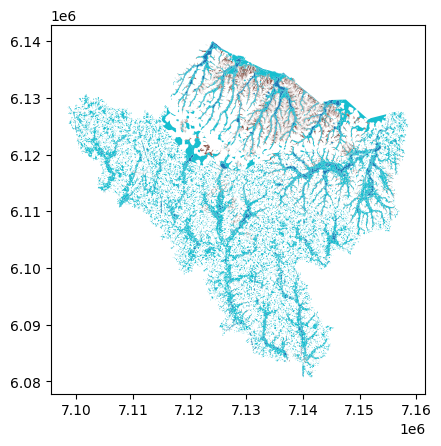

In [6]:
peligro.plot("PELIGROSID")

In [7]:
peligro.columns = peligro.columns.str.lower()

In [8]:
import rasterio
from rasterio import features
import numpy as np
from shapely.geometry import shape

# Define the target raster properties
bounds = peligro.total_bounds  # (minx, miny, maxx, maxy)

# Create a mapping from peligrosid values to numeric codes
peligrosid_mapping = {"alta": 3, "media": 2, "baja": 1}

# First rasterize at 10m resolution (original data resolution)
resolution_original = 10  # meters
width_original = int(np.ceil((bounds[2] - bounds[0]) / resolution_original))
height_original = int(np.ceil((bounds[3] - bounds[1]) / resolution_original))

transform_original = rasterio.transform.from_bounds(
    west=bounds[0],
    south=bounds[1],
    east=bounds[2],
    north=bounds[3],
    width=width_original,
    height=height_original,
)

# Rasterize at original resolution
peligro_shapes = (
    (shape(geom), peligrosid_mapping.get(val, 0))
    for geom, val in zip(peligro.geometry, peligro["peligrosid"])
)

raster_10m = features.rasterize(
    shapes=peligro_shapes,
    out_shape=(height_original, width_original),
    transform=transform_original,
    fill=0,
    dtype=np.uint8,
)

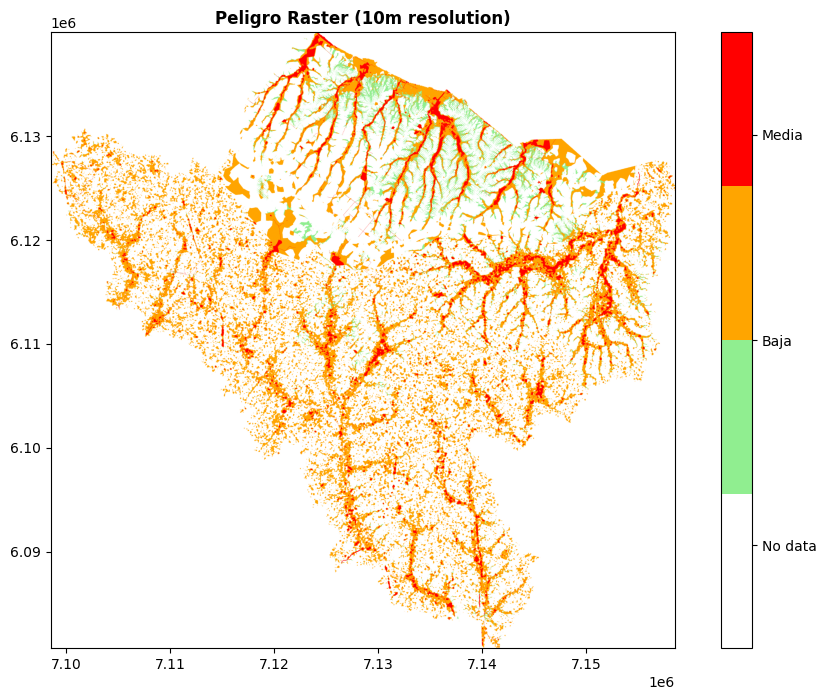

In [9]:
import matplotlib.pyplot as plt
from rasterio.plot import show

# Create a custom colormap
colors = ['white', 'lightgreen', 'orange', 'red']
cmap = plt.cm.colors.ListedColormap(colors)

# Plot using rasterio's show function
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

show(raster_10m, 
     ax=ax, 
     cmap=cmap, 
     transform=transform_original, 
     title='Peligro Raster (10m resolution)')

# Add colorbar
cbar = plt.colorbar(ax.images[0], ax=ax, ticks=[0.5, 1.5, 2.5, 3.5])
cbar.set_ticklabels(['No data', 'Baja', 'Media', 'Alta'])

plt.show()

## Exposición

In [13]:
radios_blob = bucket.blob("radios_con_datos.parquet")
radios_content = radios_blob.download_as_bytes()
radios = gpd.read_parquet(BytesIO(radios_content))  # Use radios_content, not content
radios = radios.to_crs(USE_CRS)

In [14]:
radios = radios[radios["COD_2022"] != "064417101"]

In [15]:
radios.head()

,COD_2022,PROV,DEPTO,FRACC,RADIO,OBS2022,VIV_TOT_P,POB_TOT_P,REDATAM,area_ha,densidad,exposicion,tipo_exp,jh_desoc,h_total,porcentaje,sus_eco,geometry
0,064417406,06,441,74,06,None,357,550,SI,6.81,81,Alta,Población Urbana Muy Concentrada,9,306,"2,941176471",Baja,"MULTIPOLYGON (((7138371.287 6130917.462, 71382..."
1,064416207,06,441,62,07,None,287,534,SI,21.00,25,Baja,Población Semiagrupada,7,224,"3,125",Baja,"MULTIPOLYGON (((7126244.523 6136413.316, 71262..."
2,064411704,06,441,17,04,None,319,518,SI,8.37,62,Media,Población Urbana,9,260,"3,461538462",Baja,"MULTIPOLYGON (((7139408.164 6127322.388, 71393..."
3,064412307,06,441,23,07,None,355,838,SI,12.54,67,Alta,Población Urbana Muy Concentrada,26,344,"7,558139535",Alta,"MULTIPOLYGON (((7136334.283 6129145.705, 71362..."
4,064411404,06,441,14,04,None,413,533,SI,5.98,89,Alta,Población Urbana Muy Concentrada,23,325,"7,076923077",Alta,"MULTIPOLYGON (((7139261.238 6129258.824, 71393..."


In [16]:
radios.columns = radios.columns.str.lower()

In [20]:
from rasterio.features import rasterize
from rasterio.transform import from_bounds

# First, create a raster that identifies which radio each pixel belongs to
radio_id_raster = rasterize(
    [(geom, i) for i, geom in enumerate(radios.geometry)],
    out_shape=(height_original, width_original),
    transform=transform_original,
    fill=-1,  # -1 for pixels not in any radio
    dtype=np.int32,
    all_touched=ALL_TOUCHED
)

# Create the population raster by distributing population proportionally
pob = np.zeros((height_original, width_original), dtype=float)

for i, radio in radios.iterrows():
    # Create mask for this specific radio
    radio_mask = (radio_id_raster == i)
    pixels_in_radio = np.sum(radio_mask)
    
    if pixels_in_radio > 0:
        # Distribute population evenly across all pixels in this radio
        population_per_pixel = radio['pob_tot_p'] / pixels_in_radio
        pob[radio_mask] = population_per_pixel

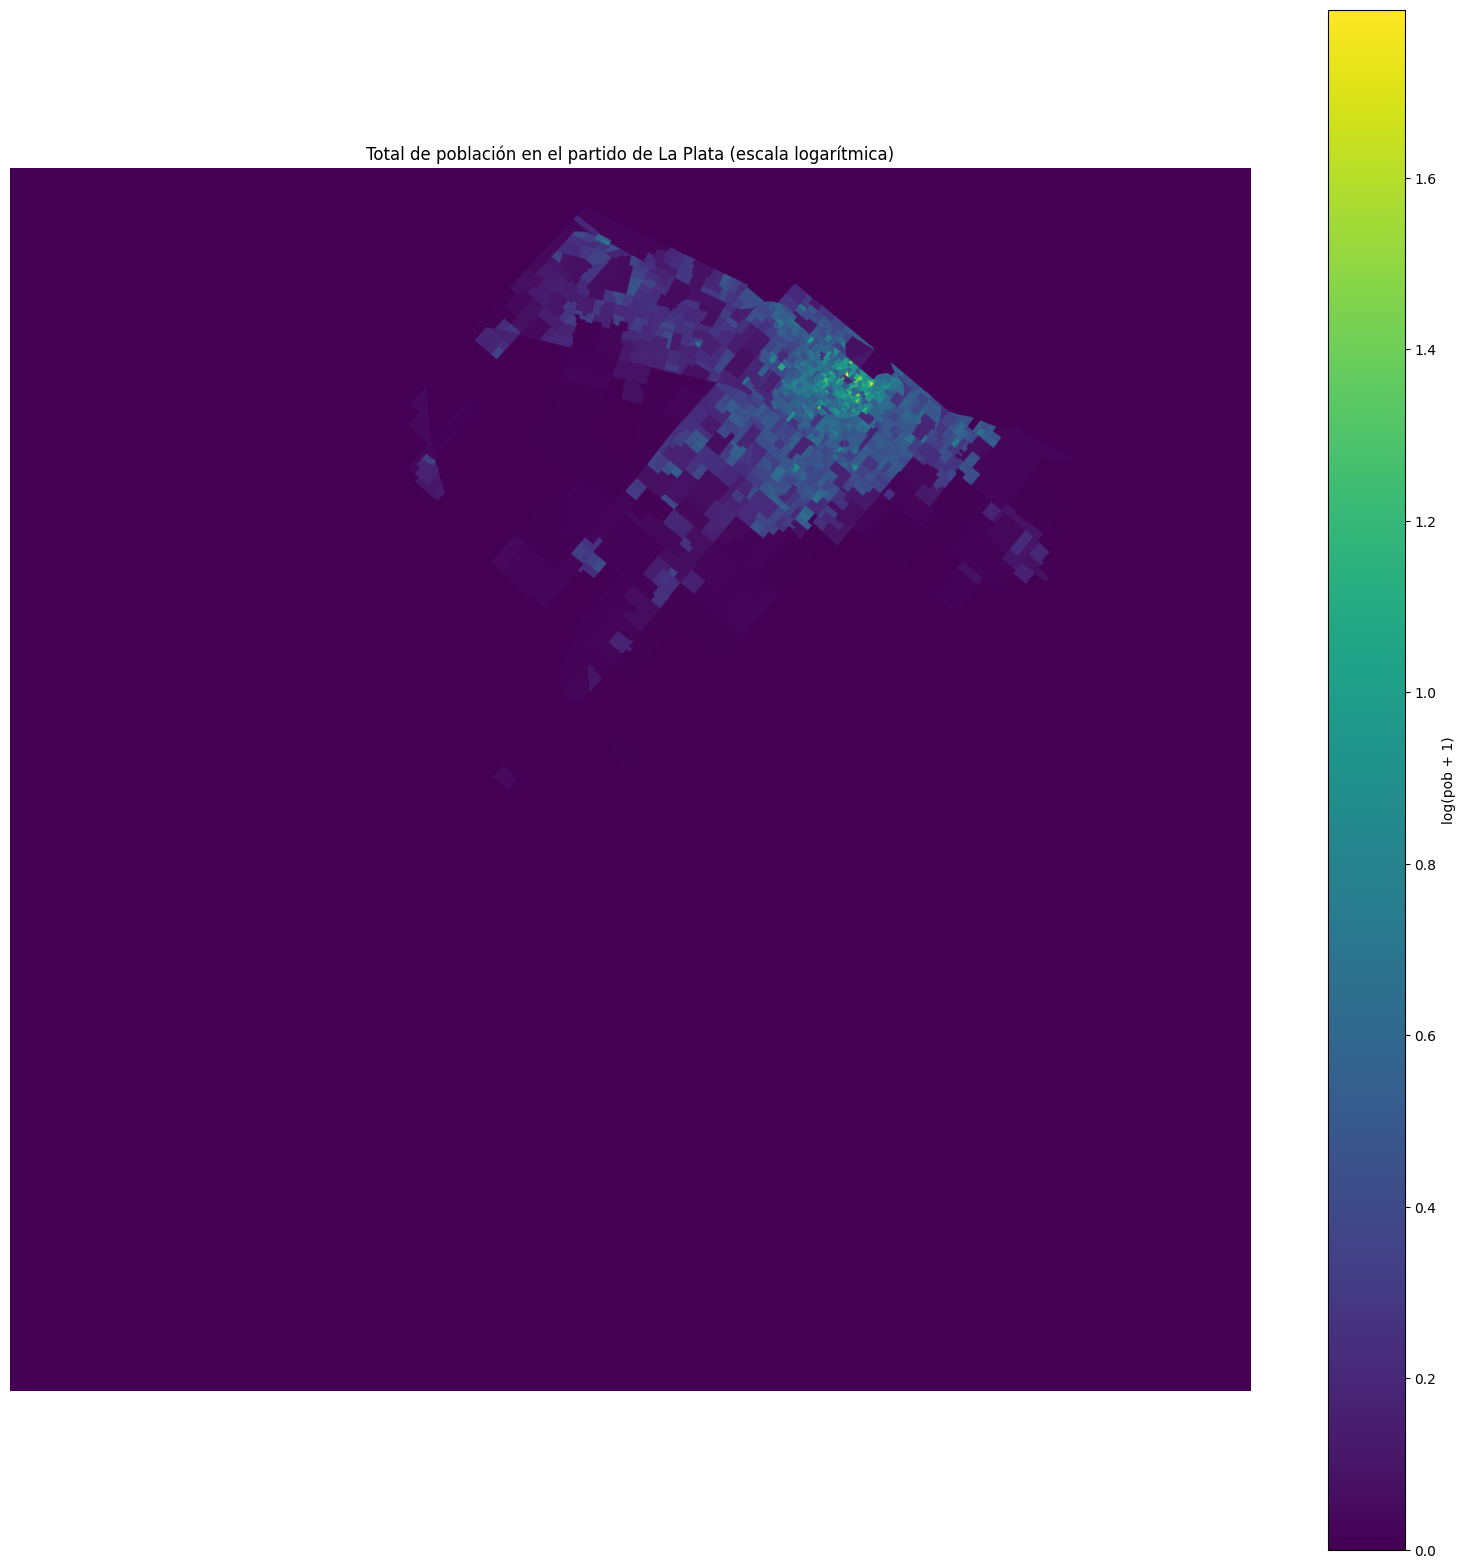

In [21]:
pob_log = np.log1p(pob)  

plt.figure(figsize=(20, 20))
plt.imshow(pob_log, cmap="viridis")
plt.title("Total de población en el partido de La Plata (escala logarítmica)")
plt.colorbar(label="log(pob + 1)")
plt.axis("off")
plt.show()

In [ ]:
# alinear los rasters de peligro y exposicion a 10m

# hacer un resumen de la poblacion segun cada categoria del raster de poblacion: alta, media y baja


peligrosid_mapping = {"alta": 3, "media": 2, "baja": 1}

In [22]:
# Calculate population statistics for each hazard category
print("Raster shapes:")
print(f"Hazard raster: {raster_10m.shape}")
print(f"Population raster: {pob.shape}")
print(f"Transform: {transform_original}")

# Create masks for each hazard category
alta_mask = (raster_10m == 3)
media_mask = (raster_10m == 2)
baja_mask = (raster_10m == 1)

# Calculate population sums for each category
pob_alta = np.sum(pob[alta_mask])
pob_media = np.sum(pob[media_mask])
pob_baja = np.sum(pob[baja_mask])

# Calculate total population in hazard zones
pob_total_hazard = pob_alta + pob_media + pob_baja

# Calculate population outside hazard zones (where hazard = 0)
pob_sin_peligro = np.sum(pob[raster_10m == 0])

# Create summary statistics
stats_summary = {
    'Alta': {
        'poblacion': int(pob_alta),
        'pixeles': int(np.sum(alta_mask)),
        'area_km2': float(np.sum(alta_mask) * 0.01),  # 10m = 0.01km
        'densidad_pob_km2': float(pob_alta / (np.sum(alta_mask) * 0.01)) if np.sum(alta_mask) > 0 else 0
    },
    'Media': {
        'poblacion': int(pob_media),
        'pixeles': int(np.sum(media_mask)),
        'area_km2': float(np.sum(media_mask) * 0.01),
        'densidad_pob_km2': float(pob_media / (np.sum(media_mask) * 0.01)) if np.sum(media_mask) > 0 else 0
    },
    'Baja': {
        'poblacion': int(pob_baja),
        'pixeles': int(np.sum(baja_mask)),
        'area_km2': float(np.sum(baja_mask) * 0.01),
        'densidad_pob_km2': float(pob_baja / (np.sum(baja_mask) * 0.01)) if np.sum(baja_mask) > 0 else 0
    },
    'Sin Peligro': {
        'poblacion': int(pob_sin_peligro),
        'pixeles': int(np.sum(raster_10m == 0)),
        'area_km2': float(np.sum(raster_10m == 0) * 0.01),
        'densidad_pob_km2': float(pob_sin_peligro / (np.sum(raster_10m == 0) * 0.01)) if np.sum(raster_10m == 0) > 0 else 0
    }
}

# Display results
print("\n=== RESUMEN DE POBLACIÓN POR CATEGORÍA DE PELIGRO ===")
print(f"{'Categoría':<15} {'Población':<12} {'Píxeles':<10} {'Área (km²)':<12} {'Densidad (hab/km²)':<20}")
print("-" * 80)

for categoria, stats in stats_summary.items():
    print(f"{categoria:<15} {stats['poblacion']:<12,} {stats['pixeles']:<10,} {stats['area_km2']:<12.2f} {stats['densidad_pob_km2']:<20.1f}")

print("-" * 80)
print(f"Total población en zonas de peligro: {pob_total_hazard:,}")
print(f"Total población: {pob_total_hazard + pob_sin_peligro:,}")

# Create a summary DataFrame for easier analysis
stats_df = pd.DataFrame.from_dict(stats_summary, orient='index')
print("\nDataFrame de estadísticas:")
print(stats_df)

Raster shapes:
Hazard raster: (5925, 6004)
Population raster: (5925, 6004)
Transform: | 10.00, 0.00, 7098513.70|
| 0.00,-10.00, 6139974.27|
| 0.00, 0.00, 1.00|

=== RESUMEN DE POBLACIÓN POR CATEGORÍA DE PELIGRO ===
Categoría       Población    Píxeles    Área (km²)   Densidad (hab/km²)  
--------------------------------------------------------------------------------
Alta            56,049       717,993    7179.93      7.8                 
Media           120,360      4,503,677  45036.77     2.7                 
Baja            157,271      698,446    6984.46      22.5                
Sin Peligro     421,835      29,653,584 296535.84    1.4                 
--------------------------------------------------------------------------------
Total población en zonas de peligro: 333,681.4460317533
Total población: 755,517.0000000012

DataFrame de estadísticas:
             poblacion   pixeles   area_km2  densidad_pob_km2
Alta             56049    717993    7179.93          7.806472
Media    

## Vulnerabilidad

In [24]:
# Define the vulnerability mapping
vulnerabilidad_mapping = {"Alta": 3, "Media": 2, "Baja": 1}

# Create the vulnerability raster with numeric values
vulnerabilidad = np.zeros((height_original, width_original), dtype=int)

for i, radio in radios.iterrows():
    # Create mask for this specific radio
    radio_mask = (radio_id_raster == i)
    
    if np.sum(radio_mask) > 0:  # Check if this radio covers any pixels
        # Get the sus_eco value and convert to numeric
        sus_eco_cat = radio['sus_eco']
        if sus_eco_cat in vulnerabilidad_mapping:
            sus_eco_value = vulnerabilidad_mapping[sus_eco_cat]
        else:
            sus_eco_value = 0  # Default value for unknown categories
        
        # Assign the same vulnerability value to ALL pixels in this radio
        vulnerabilidad[radio_mask] = sus_eco_value

print(f"Vulnerabilidad raster shape: {vulnerabilidad.shape}")
print(f"Unique vulnerability values: {np.unique(vulnerabilidad)}")
print(f"Vulnerability mapping: {vulnerabilidad_mapping}")

Vulnerabilidad raster shape: (5925, 6004)
Unique vulnerability values: [0 1 2 3]
Vulnerability mapping: {'Alta': 3, 'Media': 2, 'Baja': 1}


In [26]:
# Calculate population statistics for each vulnerability × hazard combination
print("Raster shapes:")
print(f"Hazard raster: {raster_10m.shape}")
print(f"Population raster: {pob.shape}")
print(f"Vulnerability raster: {vulnerabilidad.shape}")

# Create masks for each vulnerability category
vuln_alta_mask = (vulnerabilidad == 3)
vuln_media_mask = (vulnerabilidad == 2)
vuln_baja_mask = (vulnerabilidad == 1)

# Create masks for each hazard category
peligro_alta_mask = (raster_10m == 3)
peligro_media_mask = (raster_10m == 2)
peligro_baja_mask = (raster_10m == 1)

# Calculate population for each of the 9 combinations
# Vulnerability × Hazard matrix
exposicion_vulnerabilidad_peligro = {
    'Vuln_Alta_Peligro_Alta': np.sum(pob[vuln_alta_mask & peligro_alta_mask]),
    'Vuln_Alta_Peligro_Media': np.sum(pob[vuln_alta_mask & peligro_media_mask]),
    'Vuln_Alta_Peligro_Baja': np.sum(pob[vuln_alta_mask & peligro_baja_mask]),
    
    'Vuln_Media_Peligro_Alta': np.sum(pob[vuln_media_mask & peligro_alta_mask]),
    'Vuln_Media_Peligro_Media': np.sum(pob[vuln_media_mask & peligro_media_mask]),
    'Vuln_Media_Peligro_Baja': np.sum(pob[vuln_media_mask & peligro_baja_mask]),
    
    'Vuln_Baja_Peligro_Alta': np.sum(pob[vuln_baja_mask & peligro_alta_mask]),
    'Vuln_Baja_Peligro_Media': np.sum(pob[vuln_baja_mask & peligro_media_mask]),
    'Vuln_Baja_Peligro_Baja': np.sum(pob[vuln_baja_mask & peligro_baja_mask])
}

# Calculate population outside hazard zones (where hazard = 0)
pob_sin_peligro = np.sum(pob[raster_10m == 0])

# Create summary statistics for the 9 categories
stats_riesgo = {}
for categoria, poblacion in exposicion_vulnerabilidad_peligro.items():
    # Create mask for this specific combination
    if 'Vuln_Alta' in categoria:
        vuln_mask = vuln_alta_mask
    elif 'Vuln_Media' in categoria:
        vuln_mask = vuln_media_mask
    else:
        vuln_mask = vuln_baja_mask
        
    if 'Peligro_Alta' in categoria:
        peligro_mask = peligro_alta_mask
    elif 'Peligro_Media' in categoria:
        peligro_mask = peligro_media_mask
    else:
        peligro_mask = peligro_baja_mask
    
    # Combined mask
    combined_mask = vuln_mask & peligro_mask
    
    stats_riesgo[categoria] = {
        'poblacion': int(poblacion),
        'pixeles': int(np.sum(combined_mask)),
        'area_km2': float(np.sum(combined_mask) * 0.01),
        'densidad_pob_km2': float(poblacion / (np.sum(combined_mask) * 0.01)) if np.sum(combined_mask) > 0 else 0
    }

# Add the "Sin Peligro" category
stats_riesgo['Sin_Peligro'] = {
    'poblacion': int(pob_sin_peligro),
    'pixeles': int(np.sum(raster_10m == 0)),
    'area_km2': float(np.sum(raster_10m == 0) * 0.01),
    'densidad_pob_km2': float(pob_sin_peligro / (np.sum(raster_10m == 0) * 0.01)) if np.sum(raster_10m == 0) > 0 else 0
}

# Display results
print("\n=== MATRIZ DE RIESGO: EXPOSICIÓN × VULNERABILIDAD × PELIGRO ===")
print(f"{'Categoría':<25} {'Población':<12} {'Píxeles':<10} {'Área (km²)':<12} {'Densidad (hab/km²)':<20}")
print("-" * 90)

for categoria, stats in stats_riesgo.items():
    print(f"{categoria:<25} {stats['poblacion']:<12,} {stats['pixeles']:<10,} {stats['area_km2']:<12.2f} {stats['densidad_pob_km2']:<20.1f}")

print("-" * 90)
total_poblacion = sum(stats['poblacion'] for stats in stats_riesgo.values())
print(f"Total población: {total_poblacion:,}")

# Create a summary DataFrame for easier analysis
stats_riesgo_df = pd.DataFrame.from_dict(stats_riesgo, orient='index')

# Optional: Create a 3x3 matrix visualization
print("\n=== MATRIZ 3x3: VULNERABILIDAD × PELIGRO ===")
print("            Peligro_Alta  Peligro_Media  Peligro_Baja")
print("Vuln_Alta   ", end="")
print(f"{stats_riesgo['Vuln_Alta_Peligro_Alta']['poblacion']:>10,}  ", end="")
print(f"{stats_riesgo['Vuln_Alta_Peligro_Media']['poblacion']:>10,}  ", end="")
print(f"{stats_riesgo['Vuln_Alta_Peligro_Baja']['poblacion']:>10,}")

print("Vuln_Media  ", end="")
print(f"{stats_riesgo['Vuln_Media_Peligro_Alta']['poblacion']:>10,}  ", end="")
print(f"{stats_riesgo['Vuln_Media_Peligro_Media']['poblacion']:>10,}  ", end="")
print(f"{stats_riesgo['Vuln_Media_Peligro_Baja']['poblacion']:>10,}")

print("Vuln_Baja   ", end="")
print(f"{stats_riesgo['Vuln_Baja_Peligro_Alta']['poblacion']:>10,}  ", end="")
print(f"{stats_riesgo['Vuln_Baja_Peligro_Media']['poblacion']:>10,}  ", end="")
print(f"{stats_riesgo['Vuln_Baja_Peligro_Baja']['poblacion']:>10,}")

Raster shapes:
Hazard raster: (5925, 6004)
Population raster: (5925, 6004)
Vulnerability raster: (5925, 6004)

=== MATRIZ DE RIESGO: EXPOSICIÓN × VULNERABILIDAD × PELIGRO ===
Categoría                 Población    Píxeles    Área (km²)   Densidad (hab/km²)  
------------------------------------------------------------------------------------------
Vuln_Alta_Peligro_Alta    1,008        21,040     210.40       4.8                 
Vuln_Alta_Peligro_Media   3,052        88,702     887.02       3.4                 
Vuln_Alta_Peligro_Baja    5,584        16,585     165.85       33.7                
Vuln_Media_Peligro_Alta   17,294       45,160     451.60       38.3                
Vuln_Media_Peligro_Media  37,399       150,186    1501.86      24.9                
Vuln_Media_Peligro_Baja   49,612       124,493    1244.93      39.9                
Vuln_Baja_Peligro_Alta    37,746       355,600    3556.00      10.6                
Vuln_Baja_Peligro_Media   79,908       1,707,249  17072.49    

## Por Cuenca

In [30]:
cuencas_blob = bucket.blob("cuencas.parquet")
cuencas_content = cuencas_blob.download_as_bytes()
cuencas = gpd.read_parquet(BytesIO(cuencas_content))
cuencas = cuencas.to_crs(USE_CRS)
cuencas.columns = cuencas.columns.str.lower()

In [32]:
print(cuencas.head())

   fid  dn sup [km2]                              layer  \
0  1.0   1   108.603                  Cuenca_Aº El Gato   
1  1.0   1      None        Cuenca_Aº El Gato Extendida   
2  1.0   1    97.073        Cuenca_Aº Carnaval - Martín   
3  1.0   1     5.539            Cuenca_Aº del Zoológico   
4  1.0   1      None  Cuenca_Aº del Zoológico Extendida   

                                                path  \
0  D:/Convenio PRRI 2/SHP a compartir/Cuenca_Aº E...   
1  D:/Convenio PRRI 2/SHP a compartir/Cuenca_Aº E...   
2  D:/Convenio PRRI 2/SHP a compartir/Cuenca_Aº C...   
3  D:/Convenio PRRI 2/SHP a compartir/Cuenca_Aº d...   
4  D:/Convenio PRRI 2/SHP a compartir/Cuenca_Aº d...   

                                            geometry  
0  MULTIPOLYGON (((7134483.251 6133906.759, 71343...  
1  MULTIPOLYGON (((7134483.251 6133906.759, 71343...  
2  MULTIPOLYGON (((7125758.972 6137437.025, 71256...  
3  MULTIPOLYGON (((7139964.474 6131486.016, 71399...  
4  MULTIPOLYGON (((7139607.744 61

In [35]:
# Calculate zonal statistics for each watershed using rasterstats
from rasterstats import zonal_stats

# Create the risk raster (vulnerability × hazard combination)
riesgo_raster = vulnerabilidad * 10 + raster_10m

# Calculate zonal statistics for population within each watershed
stats_por_cuenca = zonal_stats(
    cuencas.geometry,
    pob,
    affine=transform_original,
    stats=['sum'],
    nodata_values=[0],
    prefix='pob_'
)

# Calculate zonal statistics for risk categories within each watershed
riesgo_stats_por_cuenca = zonal_stats(
    cuencas.geometry,
    riesgo_raster,
    affine=transform_original,
    stats=['count'],
    categorical=True,
    nodata_values=[0],
    prefix='riesgo_'
)

# Create tidy format
tidy_data = []

for i, cuenca in cuencas.iterrows():
    cuenca_nombre = cuenca['layer']
    pob_total = stats_por_cuenca[i]['pob_sum'] if stats_por_cuenca[i]['pob_sum'] is not None else 0
    riesgo_counts = riesgo_stats_por_cuenca[i]
    
    # Define vulnerability and hazard levels
    vulnerabilidades = ['Alta', 'Media', 'Baja']
    peligros = ['Baja', 'Media', 'Alta']
    
    for vuln_idx, vulnerabilidad in enumerate(vulnerabilidades, 1):
        for peligro_idx, peligro in enumerate(peligros, 1):
            # Calculate the risk code
            riesgo_code = vuln_idx * 10 + peligro_idx
            
            # Get pixel count for this combination
            key = f'riesgo_{riesgo_code}'
            pixeles = riesgo_counts.get(key, 0)
            
            # Calculate population proportionally
            if pob_total > 0:
                # Get total pixels for this watershed
                total_pixeles_watershed = sum(riesgo_counts.values())
                if total_pixeles_watershed > 0:
                    poblacion = (pixeles / total_pixeles_watershed) * pob_total
                else:
                    poblacion = 0
            else:
                poblacion = 0
            
            tidy_data.append({
                'cuenca': cuenca_nombre,
                'vulnerabilidad': vulnerabilidad,
                'peligro': peligro,
                'poblacion': poblacion,
                'pixeles': pixeles
            })
    
    # Add "Sin Peligro" category
    sin_peligro_pixeles = riesgo_counts.get('riesgo_0', 0)
    if pob_total > 0:
        total_pixeles_watershed = sum(riesgo_counts.values())
        if total_pixeles_watershed > 0:
            poblacion_sin_peligro = (sin_peligro_pixeles / total_pixeles_watershed) * pob_total
        else:
            poblacion_sin_peligro = 0
    else:
        poblacion_sin_peligro = 0
    
    tidy_data.append({
        'cuenca': cuenca_nombre,
        'vulnerabilidad': 'Sin Peligro',
        'peligro': 'Sin Peligro',
        'poblacion': poblacion_sin_peligro,
        'pixeles': sin_peligro_pixeles
    })

# Create DataFrame
tidy_df = pd.DataFrame(tidy_data)

# Display the tidy format
print("=== FORMATO TIDY: CUENCA × VULNERABILIDAD × PELIGRO ===")
print(tidy_df)

# Optional: Create a pivot table for easier viewing
pivot_table = tidy_df.pivot_table(
    index=['vulnerabilidad', 'peligro'],
    columns='cuenca',
    values='poblacion',
    aggfunc='sum',
    fill_value=0
)

print("\n=== TABLA PIVOT ===")
print(pivot_table)

# Save to CSV if needed
# tidy_df.to_csv('riesgo_por_cuenca_tidy.csv', index=False)

=== FORMATO TIDY: CUENCA × VULNERABILIDAD × PELIGRO ===
                  cuenca vulnerabilidad      peligro     poblacion  pixeles
0      Cuenca_Aº El Gato           Alta         Baja  18746.958980   103157
1      Cuenca_Aº El Gato           Alta        Media  20008.908079   110101
2      Cuenca_Aº El Gato           Alta         Alta   9813.362525    53999
3      Cuenca_Aº El Gato          Media         Baja   9438.812252    51938
4      Cuenca_Aº El Gato          Media        Media  12310.727806    67741
..                   ...            ...          ...           ...      ...
175  Cuenca_Aº Invernada          Media         Alta      0.000000        0
176  Cuenca_Aº Invernada           Baja         Baja      0.000000        0
177  Cuenca_Aº Invernada           Baja        Media      0.000000        0
178  Cuenca_Aº Invernada           Baja         Alta      0.000000        0
179  Cuenca_Aº Invernada    Sin Peligro  Sin Peligro      0.000000        0

[180 rows x 5 columns]

=== TAB

In [38]:
tidy_df.head(25)

,cuenca,vulnerabilidad,peligro,poblacion,pixeles
0,Cuenca_Aº El Gato,Alta,Baja,18746.958980,103157
1,Cuenca_Aº El Gato,Alta,Media,20008.908079,110101
2,Cuenca_Aº El Gato,Alta,Alta,9813.362525,53999
3,Cuenca_Aº El Gato,Media,Baja,9438.812252,51938
4,Cuenca_Aº El Gato,Media,Media,12310.727806,67741
5,Cuenca_Aº El Gato,Media,Alta,4938.757014,27176
6,Cuenca_Aº El Gato,Baja,Baja,871.951580,4798
7,Cuenca_Aº El Gato,Baja,Media,709.846368,3906
8,Cuenca_Aº El Gato,Baja,Alta,166.103323,914
9,Cuenca_Aº El Gato,Sin Peligro,Sin Peligro,0.000000,0


## Localidad

In [40]:
local_blob = bucket.blob("barrios.parquet")
local_content = local_blob.download_as_bytes()
local = gpd.read_parquet(BytesIO(local_content))
local = local.to_crs(USE_CRS)
local.columns = local.columns.str.lower()

In [43]:
print(local.head())

   fid barrio_id  sector_id sector_nom barrio_id_2         barrio_nom  \
0    1   LP-B001          2     Centro     LP-B001            La Loma   
1    2   LP-B002          2     Centro     LP-B002    19 de Noviembre   
2    3   LP-B003          2     Centro     LP-B003  Hospital Italiano   
3    4   LP-B004          2     Centro     LP-B004           Brandsen   
4    5   LP-B005          2     Centro     LP-B005           Castelli   

   delega_id                         delega_nom  \
0         77  LA PLATA CASCO URBANO FUNDACIONAL   
1         77  LA PLATA CASCO URBANO FUNDACIONAL   
2         77  LA PLATA CASCO URBANO FUNDACIONAL   
3         77  LA PLATA CASCO URBANO FUNDACIONAL   
4         77  LA PLATA CASCO URBANO FUNDACIONAL   

                                          barrio_car  \
0                   Incluye Parque Alberti (25 y 38)   
1            Incluye Plaza 19 de Noviembre (25 y 44)   
2  Incluye ZONA ESPECIAL DEL COU (Ord. 10703/2011...   
3             Incluye la Plaza

In [45]:
np.unique(vulnerabilidad)

array(['Baja'], dtype='<U4')

In [46]:
# Recreate vulnerability raster with numeric values
vulnerabilidad_mapping = {"Alta": 3, "Media": 2, "Baja": 1}

# Create the numeric vulnerability raster
vulnerabilidad_numeric = np.zeros((height_original, width_original), dtype=int)

for i, radio in radios.iterrows():
    radio_mask = (radio_id_raster == i)
    if radio['sus_eco'] in vulnerabilidad_mapping:
        vulnerabilidad_numeric[radio_mask] = vulnerabilidad_mapping[radio['sus_eco']]

# Verify the raster was created correctly
print("Unique vulnerability values:", np.unique(vulnerabilidad_numeric))
print("Vulnerability raster shape:", vulnerabilidad_numeric.shape)

# Now use vulnerabilidad_numeric instead of vulnerabilidad
riesgo_raster_local = vulnerabilidad_numeric * 10 + raster_10m

# Verify the risk raster
print("Unique risk values:", np.unique(riesgo_raster_local))

Unique vulnerability values: [0 1 2 3]
Vulnerability raster shape: (5925, 6004)
Unique risk values: [ 0  1  2  3 10 11 12 13 20 21 22 23 30 31 32 33]


In [50]:
# Calculate zonal statistics for each neighborhood using rasterstats
from rasterstats import zonal_stats

# Create the risk raster (vulnerability × hazard combination)
riesgo_raster_local = vulnerabilidad_numeric * 10 + raster_10m

# Calculate zonal statistics for population within each neighborhood
stats_por_barrio = zonal_stats(
    local.geometry,
    pob,
    affine=transform_original,
    stats=['sum'],
    nodata_values=[0],
    prefix='pob_'
)

# Calculate zonal statistics for risk categories within each neighborhood
riesgo_stats_por_barrio = zonal_stats(
    local.geometry,
    riesgo_raster_local,
    affine=transform_original,
    stats=['count'],
    categorical=True,
    nodata_values=[0],
    prefix='riesgo_'
)

# Create tidy format for neighborhoods
tidy_data_barrios = []

for i, barrio in local.iterrows():
    barrio_nombre = barrio['barrio_nom']
    sector_nombre = barrio['sector_nom']
    pob_total = stats_por_barrio[i]['pob_sum'] if stats_por_barrio[i]['pob_sum'] is not None else 0
    riesgo_counts = riesgo_stats_por_barrio[i]
    
    # Define vulnerability and hazard levels
    vulnerabilidades = ['Alta', 'Media', 'Baja']
    peligros = ['Baja', 'Media', 'Alta']
    
    for vuln_idx, vulnerabilidad in enumerate(vulnerabilidades, 1):
        for peligro_idx, peligro in enumerate(peligros, 1):
            # Calculate the risk code
            riesgo_code = vuln_idx * 10 + peligro_idx
            
            # Get pixel count for this combination
            key = f'riesgo_{riesgo_code}'
            pixeles = riesgo_counts.get(key, 0)
            
            # Calculate population proportionally
            if pob_total > 0:
                # Get total pixels for this neighborhood
                total_pixeles_barrio = sum(riesgo_counts.values())
                if total_pixeles_barrio > 0:
                    poblacion = (pixeles / total_pixeles_barrio) * pob_total
                else:
                    poblacion = 0
            else:
                poblacion = 0
            
            tidy_data_barrios.append({
                'barrio_id': barrio['barrio_id'],
                'barrio_nom': barrio_nombre,
                'sector_nom': sector_nombre,
                'vulnerabilidad': vulnerabilidad,
                'peligro': peligro,
                'poblacion': poblacion,
                'pixeles': pixeles
            })
    
    # Add "Sin Peligro" category
    sin_peligro_pixeles = riesgo_counts.get('riesgo_0', 0)
    if pob_total > 0:
        total_pixeles_barrio = sum(riesgo_counts.values())
        if total_pixeles_barrio > 0:
            poblacion_sin_peligro = (sin_peligro_pixeles / total_pixeles_barrio) * pob_total
        else:
            poblacion_sin_peligro = 0
    else:
        poblacion_sin_peligro = 0
    
    tidy_data_barrios.append({
        'barrio_id': barrio['barrio_id'],
        'barrio_nom': barrio_nombre,
        'sector_nom': sector_nombre,
        'vulnerabilidad': 'Sin Peligro',
        'peligro': 'Sin Peligro',
        'poblacion': poblacion_sin_peligro,
        'pixeles': sin_peligro_pixeles
    })

# Create DataFrame
tidy_df_barrios = pd.DataFrame(tidy_data_barrios)

# Display the tidy format
print("=== FORMATO TIDY: BARRIOS × VULNERABILIDAD × PELIGRO ===")
print(tidy_df_barrios.head(20))


# Summary statistics
print("\n=== RESUMEN ESTADÍSTICO ===")
print(f"Total barrios: {len(local)}")
print(f"Total sectores: {local['sector_nom'].nunique()}")

# Population summary by sector
print("\n=== POBLACIÓN POR SECTOR ===")
pob_por_sector = tidy_df_barrios.groupby('sector_nom')['poblacion'].sum().sort_values(ascending=False)
print(pob_por_sector)

tidy_df_barrios

=== FORMATO TIDY: BARRIOS × VULNERABILIDAD × PELIGRO ===
   barrio_id       barrio_nom sector_nom vulnerabilidad      peligro  \
0    LP-B001          La Loma     Centro           Alta         Baja   
1    LP-B001          La Loma     Centro           Alta        Media   
2    LP-B001          La Loma     Centro           Alta         Alta   
3    LP-B001          La Loma     Centro          Media         Baja   
4    LP-B001          La Loma     Centro          Media        Media   
5    LP-B001          La Loma     Centro          Media         Alta   
6    LP-B001          La Loma     Centro           Baja         Baja   
7    LP-B001          La Loma     Centro           Baja        Media   
8    LP-B001          La Loma     Centro           Baja         Alta   
9    LP-B001          La Loma     Centro    Sin Peligro  Sin Peligro   
10   LP-B002  19 de Noviembre     Centro           Alta         Baja   
11   LP-B002  19 de Noviembre     Centro           Alta        Media   
12   LP

,barrio_id,barrio_nom,sector_nom,vulnerabilidad,peligro,poblacion,pixeles
0,LP-B001,La Loma,Centro,Alta,Baja,939.799231,2860
1,LP-B001,La Loma,Centro,Alta,Media,758.082806,2307
2,LP-B001,La Loma,Centro,Alta,Alta,1192.493499,3629
3,LP-B001,La Loma,Centro,Media,Baja,64.734423,197
4,LP-B001,La Loma,Centro,Media,Media,76.564063,233
...,...,...,...,...,...,...,...
5215,EP-B23,La Familia II,Sudoeste,Media,Alta,0.000000,0
5216,EP-B23,La Familia II,Sudoeste,Baja,Baja,0.000000,0
5217,EP-B23,La Familia II,Sudoeste,Baja,Media,0.000000,0
5218,EP-B23,La Familia II,Sudoeste,Baja,Alta,0.000000,0


In [49]:
tidy_df_barrios.head(20)

,barrio_id,barrio_nom,sector_nom,cuenca_nom,vulnerabilidad,peligro,poblacion,pixeles
0,LP-B001,La Loma,Centro,El Gato (Arroyo Pérez),Alta,Baja,939.799231,2860
1,LP-B001,La Loma,Centro,El Gato (Arroyo Pérez),Alta,Media,758.082806,2307
2,LP-B001,La Loma,Centro,El Gato (Arroyo Pérez),Alta,Alta,1192.493499,3629
3,LP-B001,La Loma,Centro,El Gato (Arroyo Pérez),Media,Baja,64.734423,197
4,LP-B001,La Loma,Centro,El Gato (Arroyo Pérez),Media,Media,76.564063,233
5,LP-B001,La Loma,Centro,El Gato (Arroyo Pérez),Media,Alta,194.203268,591
6,LP-B001,La Loma,Centro,El Gato (Arroyo Pérez),Baja,Baja,77.221265,235
7,LP-B001,La Loma,Centro,El Gato (Arroyo Pérez),Baja,Media,0.328601,1
8,LP-B001,La Loma,Centro,El Gato (Arroyo Pérez),Baja,Alta,0.000000,0
9,LP-B001,La Loma,Centro,El Gato (Arroyo Pérez),Sin Peligro,Sin Peligro,0.000000,0


## Por Sector

In [51]:
# Create summary tidy DataFrame by sector (non-spatial aggregation)
print("=== RESUMEN TIDY POR SECTOR ===")

# Group by sector, vulnerability, and hazard, then sum population and pixels
tidy_sectores = tidy_df_barrios.groupby(['sector_nom', 'vulnerabilidad', 'peligro']).agg({
    'poblacion': 'sum',
    'pixeles': 'sum'
}).reset_index()

# Display the sector summary
print("Tidy format por sector:")
print(tidy_sectores)

# Summary statistics by sector
print("\n=== ESTADÍSTICAS POR SECTOR ===")
for sector in tidy_sectores['sector_nom'].unique():
    sector_data = tidy_sectores[tidy_sectores['sector_nom'] == sector]
    total_pob = sector_data['poblacion'].sum()
    print(f"\n{sector}:")
    print(f"  Población total: {total_pob:,.0f}")
    
    # Show distribution by vulnerability and hazard
    for _, row in sector_data.iterrows():
        if row['vulnerabilidad'] != 'Sin Peligro':
            print(f"    {row['vulnerabilidad']} × {row['peligro']}: {row['poblacion']:,.0f} hab")

=== RESUMEN TIDY POR SECTOR ===
Tidy format por sector:
   sector_nom vulnerabilidad      peligro     poblacion  pixeles
0      Centro           Alta         Alta  12919.226249    42517
1      Centro           Alta         Baja  19715.689133    66227
2      Centro           Alta        Media  18232.595147    60158
3      Centro           Baja         Alta    316.426550     1177
4      Centro           Baja         Baja   1924.085531     5476
5      Centro           Baja        Media   1047.539502     5875
6      Centro          Media         Alta   4659.495343    15806
7      Centro          Media         Baja  11343.402241    33480
8      Centro          Media        Media   9302.415833    31193
9      Centro    Sin Peligro  Sin Peligro      9.123908       50
10      Norte           Alta         Alta   2680.418797    38039
11      Norte           Alta         Baja  14740.094279   136452
12      Norte           Alta        Media  10299.680264   138291
13      Norte           Baja      

In [53]:
tidy_sectores[["sector_nom", "vulnerabilidad", "peligro", "poblacion"]]

,sector_nom,vulnerabilidad,peligro,poblacion
0,Centro,Alta,Alta,12919.226249
1,Centro,Alta,Baja,19715.689133
2,Centro,Alta,Media,18232.595147
3,Centro,Baja,Alta,316.426550
4,Centro,Baja,Baja,1924.085531
5,Centro,Baja,Media,1047.539502
6,Centro,Media,Alta,4659.495343
7,Centro,Media,Baja,11343.402241
8,Centro,Media,Media,9302.415833
9,Centro,Sin Peligro,Sin Peligro,9.123908
